In [3]:
import numpy as np
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from ipywidgets import interact
from os import path

import plotly.graph_objects as go
import pandas as pd

from quimb import *
import time


In [4]:
def Hilbertspace_Zr(N,r):

    states=np.zeros((r**N,N),dtype=int)

    if N>0:
        for i_1 in range(r**N):
            num_str=np.base_repr(i_1,base=r)[::-1]
            for i_2 in range(len(num_str)):
                states[i_1,i_2]=int(num_str[i_2])
    else:
        states=[[0]]
        
    return states

def p_transpose_2(V,Na,Nb):
# partial transpose with respect to subsystem 2
# the basis of NaxNb density matrix is defined by Nb*(i-1)+j,
# i,j=1,2,3 spans the Hilbert space of subsystem 1 and 2 respectively
    U=np.zeros((Na*Nb,Na*Nb), dtype=np.complex128)
    for i_1 in range(Na):
        for i_2 in range(Na):
#             print(V[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)].shape)
            U[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)]=np.transpose(V[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)])

    return U

def vNent_calc(rho,epsilon=1e-9):
    chi0 =np.linalg.eigvalsh(rho)
    chi1=chi0[np.nonzero(np.abs(chi0)>epsilon)]
    chi2=chi1[np.nonzero(np.abs(chi1-1)>epsilon)]
    return -np.sum(chi2*np.log(chi2))


In [307]:
from scipy.integrate import quad, nquad

def Gz(z,a,b):
    '''Direct solution to G(z), faster but has numerical instability for large V
    a=  Lb/L2
    b=  Lb*L1/L2
    '''
    a2= (b-1)/z +1j*0
    a1= (a-z)/z +1j*0
    a0= 1/z +1j*0
    Q= (3*a1-a2**2)/9 +1j*0
    R= (9*a2*a1-27*a0-2*a2**3)/54 +1j*0
    D= Q**3 + R**2 +1j*0
    S= (R+D**0.5 +1j*0)**(1/3)
    T= (R-D**0.5 +1j*0)**(1/3)
    z4= -a2/3 + (1-1j*sqrt(3))*Q/S/2-(1+1j*sqrt(3))/2*S
    return np.abs(np.imag(z4))

def integrand(z, a, b):
    return Gz(z,a,b)*np.abs(z)

def neg_calc(a,b):
    '''Calculates logneg by \int P(z)|z| dz
    where P(z) is spectral density'''
    options={'limit':500}
    integral= nquad(integrand, [[-np.inf, np.inf]], args=(a, b),opts=[options,options])[0]
    return integral


In [338]:
Nrep=300
r=2 # local Hilbert space dim

La=4
Lb=8
Na=r**La
Nb=r**Lb
Nab = int(Na*Nb)

Lc_sw=[La]

vT=np.zeros((Nrep*Nb*Na,len(Lc_sw)))

t_timer= time.time()
for i_l in range(len(Lc_sw)):
    Lc=Lc_sw[i_l]
    print(Lc)
    Nc=r**Lc
    
    for i_r in range(Nrep):
        X=np.random.randn(Nab,Nc)+1j*np.random.randn(Nab,Nc)

        mat=np.dot(X,np.matrix(X).H)
        rho= mat / np.trace(mat)
        rT2 = p_transpose_2(rho,Na,Nb)
        l1T=np.linalg.eigvalsh(rT2)
        vT[i_r*Nb*Na:(i_r+1)*Nb*Na,i_l] = Nab*l1T
        
    out_dir = 'data/' 
    f1= 'NS_Labc_%d_%d_%d.npz' % (La,Lb,Lc)
    fname = out_dir+ f1
    np.savez(fname, e0=vT[:,i_l], Nrep=Nrep)

elapsed = time.time() - t_timer
print("Finished, elapsed time = %.2f " % (elapsed)+ "sec")

4
Finished, elapsed time = 3438.93 sec


ES was loaded!


TypeError: expected non-empty vector for x

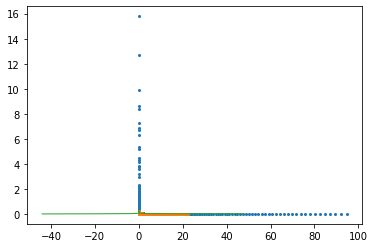

In [339]:
n_sum=Nrep*Na*Nb


plt.figure()

for i_l in range(len(Lc_sw)):
    Lc=Lc_sw[i_l]

    out_dir = 'data/' 
    f1= 'NS_Labc_%d_%d_%d.npz' % (La,Lb,Lc)
    fname = out_dir+f1

    npzfile = np.load(fname)
    vT0=npzfile['e0']
    print('ES was loaded!')


    num_bins1=2000
#     n0, bin_edges0 = np.histogram(vT0, bins=num_bins1)
#     bins_center0= (bin_edges0[0:num_bins1]+ bin_edges0[1:])/2
#     n0= n0/n_sum/(bin_edges0[1]-bin_edges0[0])
#     plt.plot(bins_center0,n0,'o',markersize=2)
#     i_p = np.argwhere(bins_center0>1e-12)
#     plt.plot(bins_center0[i_p],n0[i_p],'o',markersize=2)
#     i_n = np.argwhere(bins_center0<=0)
#     plt.plot(-bins_center0[i_n],n0[i_n],'o',markersize=2)
 
    nb1 = int(num_bins1/2)
    b1 = np.sort(np.concatenate((-np.logspace(-10,1.35,nb1+1),np.logspace(-10,2,nb1))))
    n0, bin_edges0 = np.histogram(vT0, bins=b1)
    n0= n0/n_sum/np.diff(bin_edges0)
    i_p = np.argwhere(b1>0)
    plt.plot(b1[i_p[:-2]],n0[i_p[:-2]],'o',markersize=2)
    i_n = np.argwhere(b1<=0)
    plt.plot(-b1[i_n],n0[i_n],'o',markersize=2)

    a = Nc/Nb +1j*0
    b = Nc/Nb*Na +1j*0
    fx =  Nb/Nc
    fy =  Nc/pi/Nb
    xplot= np.linspace(bins_center0.min(),bins_center0.max(),2000)/fx*1.1 #+1j*1e-12
    yplot=np.abs(Gz(xplot,a,b))
#     yplot_eq=Gz_eq(np.ndarray.tolist(xplot),a+1j*0,b+1j*0)
    plt.plot(xplot*fx,fy*yplot,linewidth=1)

     
#     xx = np.logspace(-2.5,1)
# # plt.plot(xx,0.1/xx**0.33,"--",label=r"$1/z^{1/3}$")
# # plt.plot(xx,0.04/xx**0.5,"--",label=r"$1/z^{1/2}$")

    i_p = np.argwhere(b1>3e-2)
    n_p = np.reshape(n0[i_p[:-2]],[len(i_p[:-2]),])
    i_p_max = np.argwhere(n_p>2e-1)
    bins_p = np.reshape(b1[i_p[:-2]],[len(i_p[:-2]),])
    z = np.polyfit(np.log(bins_p[i_p_max][:,0]),np.log(n_p[i_p_max][:,0]),1)
    plt.plot(xx,np.exp(z[1]+np.log(xx)*z[0]),"k--", label=r"$z^{%.2f}$" % (z[0]))

    i_n = np.argwhere(b1<-3e-2)
    n_n = np.reshape(n0[i_n],[len(i_n),])
    i_n_max = np.argwhere(n_n>7e-2)
    bins_n = np.reshape(b1[i_n],[len(i_n),])
    z = np.polyfit(np.log(-bins_n[i_n_max][:,0]),np.log(n_n[i_n_max][:,0]),1)
    plt.plot(xx,np.exp(z[1]+np.log(xx)*z[0]),"g--", label=r"$z^{%.2f}$" % (z[0]))
    
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-2,2e1)
plt.xlim(1e-3,2e1)
plt.legend()
plt.show()

# db0=bins_center0[-1]-bins_center0[0]
# db1=bins_center1[-1]-bins_center1[0]

# print('vertical ratio: ',np.max(n1)/np.max(n0))
# print('horizontal ratio: ',db1/db0)
# print(n_sum-Nrep*Na*Nb)

ES was loaded!


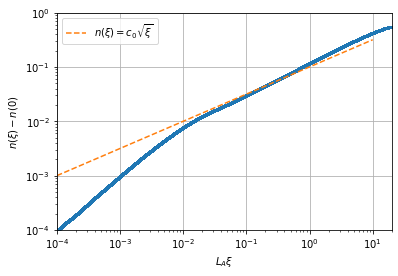

In [337]:
# cumulative probability

n_sum=Nrep*Na*Nb


plt.figure()

for i_l in range(len(Lc_sw)):
    Lc=Lc_sw[i_l]

    out_dir = 'data/' 
    f1= 'NS_Labc_%d_%d_%d.npz' % (La,Lb,Lc)
    fname = out_dir+f1

    npzfile = np.load(fname)
    vT0=npzfile['e0']
    print('ES was loaded!')
    
    vs = np.sort(vT0)
    plt.plot(vs,np.linspace(1/len(vT0),1,len(vT0))-0.4375,"o",markersize=2)
     
#     xx = np.logspace(-2.5,1)
# # plt.plot(xx,0.1/xx**0.33,"--",label=r"$1/z^{1/3}$")
# # plt.plot(xx,0.04/xx**0.5,"--",label=r"$1/z^{1/2}$")

#     i_p = np.argwhere(b1>3e-2)
#     n_p = np.reshape(n0[i_p[:-2]],[len(i_p[:-2]),])
#     i_p_max = np.argwhere(n_p>2e-1)
#     bins_p = np.reshape(b1[i_p[:-2]],[len(i_p[:-2]),])
#     z = np.polyfit(np.log(bins_p[i_p_max][:,0]),np.log(n_p[i_p_max][:,0]),1)
#     plt.plot(xx,np.exp(z[1]+np.log(xx)*z[0]),"k--", label=r"$z^{%.2f}$" % (z[0]))

#     i_n = np.argwhere(b1<-3e-2)
#     n_n = np.reshape(n0[i_n],[len(i_n),])
#     i_n_max = np.argwhere(n_n>7e-2)
#     bins_n = np.reshape(b1[i_n],[len(i_n),])
#     z = np.polyfit(np.log(-bins_n[i_n_max][:,0]),np.log(n_n[i_n_max][:,0]),1)
#     plt.plot(xx,np.exp(z[1]+np.log(xx)*z[0]),"g--", label=r"$z^{%.2f}$" % (z[0]))
    
xx = np.logspace(-4,1)
plt.plot(xx,0.1*xx**0.5,"--", label=r"$n(\xi)=c_0\sqrt{\xi}$")

plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-4,1)
plt.xlim(1e-4,2e1)
plt.grid()
plt.legend()
plt.xlabel(r"$L_A \xi$")
plt.ylabel(r"$n(\xi)-n(0)$")
plt.show()

# db0=bins_center0[-1]-bins_center0[0]
# db1=bins_center1[-1]-bins_center1[0]

# print('vertical ratio: ',np.max(n1)/np.max(n0))
# print('horizontal ratio: ',db1/db0)
# print(n_sum-Nrep*Na*Nb)

In [335]:
i1=np.argmin(np.abs(vs))
print(i1/len(vT0))

2240000


In [336]:
2240000/len(vT0)

0.4375